# Import

## Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/VinBigData/Procesamiento de lenguajes naturales/Project"

/content/drive/MyDrive/VinBigData/Procesamiento de lenguajes naturales/Project


## Other libraries

In [ ]:
!pip install datasets==2.19.2 transformers==4.41.2 huggingface-hub

In [ ]:
import torch
from transformers import TrainerCallback, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import json
import pandas as pd

from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split

import random

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Config

In [ ]:
max_token_length = 256
epochs = 10
sample_used = 10
testing = False

batch_size = 32
learning_rate = 2e-5
weight_decay = 1e-3

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data preprocessing

In [ ]:
# Example DataFrame
data = pd.read_csv("./fixed_data.csv")
data_loc = data[["content", "label"]]
df = pd.DataFrame(data_loc)
df = df.loc[df["label"] <= 1]
df = df.dropna()

# Convert DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df)

# Optional: remove the automatic index column (if generated)
hf_dataset = hf_dataset.remove_columns("__index_level_0__")

print(hf_dataset)


Dataset({
    features: ['content', 'label'],
    num_rows: 3770
})


In [ ]:
df.head()

content  label
0  bca bắt 2 chủ tịch tỉnh và một loạt tòng phạm ...      0
1  luật sư tố những thủ đoạn ăn gian điện của evn...      1
2  trước khi scb mất 1 triệu tỷ, từng có 70 lượt ...      1
3  bốn công an làm giấy xác nhận lập công giả cho...      0
4  nữ đồng chí tài xế say xỉn gây tai nạn là con ...      1

In [ ]:
for i in range(len(df)):
    if isinstance(df.iloc[i]["content"], str) is False:
        print(i, df.iloc[i]["content"])

In [ ]:
df["label"].value_counts()

label
0    3171
1     599
Name: count, dtype: int64

In [ ]:
# Step 2: Split Dataset (80% train, 10% val, 10% test)
train_testvalid = hf_dataset.train_test_split(test_size=0.2, seed=42)  # 80% train, 20% temp
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)  # 10% test, 10% val

# Step 3: Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

# remove __index_level_0__
# dataset = dataset.remove_columns("__index_level_0__")

# Optional: Verify the splits
print(dataset)

# Output sample sizes
print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")


DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 3016
    })
    validation: Dataset({
        features: ['content', 'label'],
        num_rows: 377
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 377
    })
})
Train size: 3016
Validation size: 377
Test size: 377


In [ ]:
def random_used():
    random.seed(42)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["train"])), sample_used)

    # Select the samples using the indices
    dataset["train"] = dataset["train"].select(random_indices)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["validation"])), sample_used)

    # Select the samples using the indices
    dataset["validation"] = dataset["validation"].select(random_indices)

    # Sample 500 random indices
    random_indices = random.sample(range(len(dataset["test"])), sample_used)

    # Select the samples using the indices
    dataset["test"] = dataset["test"].select(random_indices)

if testing:
    random_used()

In [ ]:
# Load model directly
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    print(type(examples['content']))
    #return tokenizer(examples["content"], truncation=True)
    return tokenizer(examples['content'], padding='max_length', truncation=True, max_length=max_token_length)

In [ ]:
tokenized_train = dataset["train"].map(preprocess_function, batched=True)
tokenized_val = dataset["validation"].map(preprocess_function, batched=True)
tokenized_test = dataset["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/3016 [00:00<?, ? examples/s]

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


Map:   0%|          | 0/377 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/377 [00:00<?, ? examples/s]

<class 'list'>


In [ ]:
print(tokenized_train[0]["input_ids"])
print(len(tokenized_train[0]["input_ids"]))
print(tokenized_train[0])

# get max token length of tokenized train val test
max_token_dataset = 0
for i in range(len(tokenized_train)):
    if len(tokenized_train[i]["input_ids"]) > max_token_dataset:
        max_token_dataset = len(tokenized_train[i]["input_ids"])
for i in range(len(tokenized_val)):
    if len(tokenized_val[i]["input_ids"]) > max_token_dataset:
        max_token_dataset = len(tokenized_val[i]["input_ids"])
for i in range(len(tokenized_test)):
    if len(tokenized_test[i]["input_ids"]) > max_token_dataset:
        max_token_dataset = len(tokenized_test[i]["input_ids"])

print(max_token_dataset)

[0, 1294, 2528, 3739, 1901, 1133, 5841, 34, 84, 8474, 2947, 1776, 31, 2644, 2752, 53, 36, 43, 7303, 5761, 380, 212, 34, 454, 84, 8474, 2947, 1776, 31, 2644, 22178, 1301, 4, 2792, 525, 1766, 7038, 98, 2892, 6536, 31, 4692, 5673, 6, 16, 100, 807, 626, 66, 40, 9, 12053, 1294, 14114, 35, 272, 184, 17033, 2008, 4, 4762, 19270, 1395, 4, 197, 2033, 1440, 574, 2178, 34, 454, 109, 23, 30, 185, 474, 34889, 13208, 1591, 20952, 4, 184, 5843, 8474, 378, 878, 1981, 16788, 16, 100, 626, 5924, 39, 7452, 3664, 28, 6278, 3664, 35, 21, 687, 4439, 819, 359, 42, 10, 3419, 363, 2657, 55582, 1395, 65, 1201, 5924, 1901, 3224, 1133, 5841, 9, 212, 2288, 397, 1069, 1864, 52400, 1701, 4, 15, 137, 139, 76, 810, 1201, 5924, 99, 10997, 1926, 12584, 71, 32504, 1187, 4, 2792, 525, 1201, 5924, 9, 1901, 63, 1465, 701, 819, 24, 3224, 1133, 1210, 1948, 56035, 4, 510, 19459, 1881, 4, 510, 687, 17, 13, 996, 61097, 13208, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=max_token_length)

# Model

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

# Metrics

In [ ]:
import datasets
metrics_list = datasets.load_metric('glue', 'mrpc', trust_remote_code=True)

<ipython-input-29-cac80a8b0bdc>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = datasets.load_metric('glue', 'mrpc', trust_remote_code=True)


In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(predictions)
    return metrics_list.compute(predictions=predictions, references=labels)

# Train

In [ ]:
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_acc = []
        self.eval_f1 = []
        self.epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(logs)
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
                self.epochs.append(int(logs["epoch"]))
            if "eval_loss" in logs:
                self.eval_loss.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.eval_acc.append(logs["eval_accuracy"])
            if "eval_f1" in logs:
                self.eval_f1.append(logs["eval_f1"])

            print(self.train_loss)
            print(self.epochs)
            print(self.eval_loss)

# Assuming you have these objects already
# model, tokenizer, train_dataset, eval_dataset

In [ ]:
# Initialize the LossHistoryCallback
loss_history = LossHistoryCallback()

training_args = TrainingArguments(
    output_dir="/content/eval",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=weight_decay,
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=epochs,
    report_to=None,
    fp16=(device == "cuda"),
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_history],
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# trainer.train()

{'loss': 1.3312, 'grad_norm': 34.21127700805664, 'learning_rate': 1.9978947368421054e-05, 'epoch': 0.010526315789473684}
[1.3312]
[0]
[]
{'loss': 1.2072, 'grad_norm': 41.83137130737305, 'learning_rate': 1.9957894736842107e-05, 'epoch': 0.021052631578947368}
[1.3312, 1.2072]
[0, 0]
[]
{'loss': 0.5009, 'grad_norm': 40.89106369018555, 'learning_rate': 1.993684210526316e-05, 'epoch': 0.031578947368421054}
[1.3312, 1.2072, 0.5009]
[0, 0, 0]
[]
{'loss': 0.6696, 'grad_norm': 10.589482307434082, 'learning_rate': 1.9915789473684212e-05, 'epoch': 0.042105263157894736}
[1.3312, 1.2072, 0.5009, 0.6696]
[0, 0, 0, 0]
[]
{'loss': 0.8914, 'grad_norm': 2.9163625240325928, 'learning_rate': 1.9894736842105265e-05, 'epoch': 0.05263157894736842}
[1.3312, 1.2072, 0.5009, 0.6696, 0.8914]
[0, 0, 0, 0, 0]
[]
{'loss': 0.9608, 'grad_norm': 3.923304796218872, 'learning_rate': 1.9873684210526318e-05, 'epoch': 0.06315789473684211}
[1.3312, 1.2072, 0.5009, 0.6696, 0.8914, 0.9608]
[0, 0, 0, 0, 0, 0]
[]
{'loss': 0.64,

TrainOutput(global_step=950, training_loss=0.13769471290864443, metrics={'train_runtime': 600.1459, 'train_samples_per_second': 50.254, 'train_steps_per_second': 1.583, 'total_flos': 3967750339338240.0, 'train_loss': 0.13769471290864443, 'epoch': 10.0})

# Final evaluation

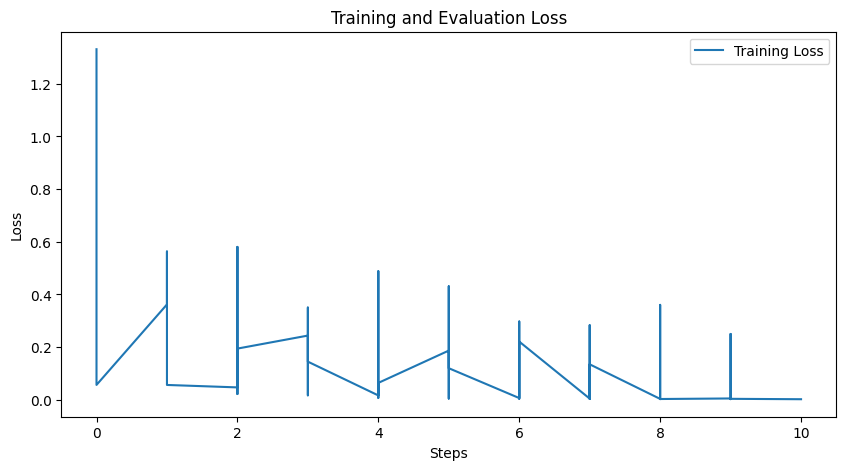

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.train_loss, label="Training Loss")
#plt.plot(loss_history.epochs, loss_history.eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss")

plt.savefig("./eval/train_val_loss.png")
plt.show()
plt.clf()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.eval_acc, label="Evaluation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evaluation Accuracy")

plt.savefig("./eval/val_acc.png")
plt.show()

plt.clf()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history.epochs, loss_history.eval_f1, label="Evaluation F1")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Evaluation F1 score")

plt.savefig("./eval/val_f1.png")
plt.show()

plt.clf()

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_val)

In [ ]:
data_dict = compute_metrics((predictions, labels))

In [ ]:
data_dict_new = trainer.evaluate()
for key, item in data_dict_new.items():
    data_dict[key] = item

with open("./eval/final_eval.json", "w") as file:
    json.dump(data_dict, file)

data_dict

# Inference

In [ ]:
text = "Đảng làm việc rất tốt"

In [ ]:
from transformers import pipeline

model_name = "./eval/checkpoint-950"
classifier = pipeline("text-classification", model=model_name)

def inference_from_pipeline(text, model_name):
    return classifier(text)

def inference_directly(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Ensure the inputs are on the correct device
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    # Generate predictions
    with torch.no_grad():
        outputs = trainer.model(**inputs)
        logits = outputs.logits

    predictions = np.argmax(logits, axis=1)
    pred_class = trainer.model.config.id2label[int(predictions)]

    #decoded_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return pred_class, logits


In [ ]:
inference_directly(text)

('POS', tensor([[-2.8035,  3.5366, -0.7991]]))